In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
import sklearn
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

[nltk_data] Downloading package stopwords to C:\Users\USER-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('input_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10106 entries, 0 to 10105
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Original      10106 non-null  object
 1   PrivacyRatio  10106 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 158.0+ KB


<AxesSubplot:>

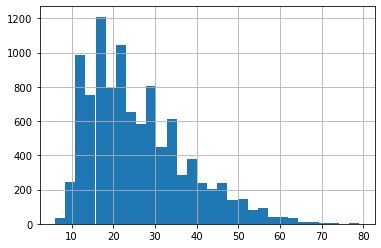

In [4]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['Original']]

pd.Series(seq_len).hist(bins = 30)

In [5]:
df_3 = df.copy()
df_4 = df.copy()
from collections import Counter
for i, row in df_3.iterrows():
    if row['PrivacyRatio'] >= 3:
        df_3.loc[i, 'PrivacyRatio'] = 1
    else:
        df_3.loc[i, 'PrivacyRatio'] = 0
# Counter(df['label'])
Counter(df_3['PrivacyRatio'])

Counter({1: 5536, 0: 4570})

In [6]:
from collections import Counter
for i, row in df_4.iterrows():
    if row['PrivacyRatio'] >= 4:
        df_4.loc[i, 'PrivacyRatio'] = 1
    else:
        df_4.loc[i, 'PrivacyRatio'] = 0
# Counter(df['label'])
Counter(df_4['PrivacyRatio'])

Counter({1: 3696, 0: 6410})

<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

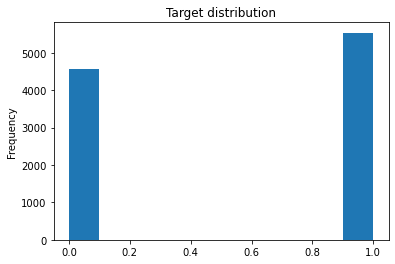

In [7]:
# df.target.plot(kind='hist', title='Target distribution')
df_3.PrivacyRatio.plot(kind='hist', title='Target distribution')

<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

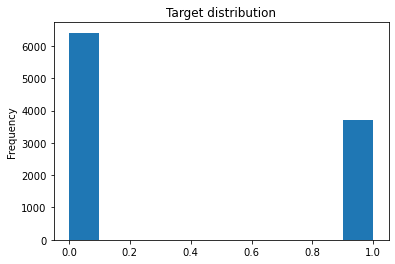

In [8]:
df_4.PrivacyRatio.plot(kind='hist', title='Target distribution')

In [9]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(s):
    result = []
    word_tokens = word_tokenize(s)

    for token in word_tokens:
        if token not in stop_words:
            result.append(token)
    s = ' '.join(result)  # Converting list to string
    return s

df_3['Original'] = df_3['Original'].apply(remove_stopwords) # Text preprocessing
df_4['Original'] = df_4['Original'].apply(remove_stopwords)
df_3 = sklearn.utils.shuffle(df_3)
df_4 = sklearn.utils.shuffle(df_4)
df_3.head()

,Original,PrivacyRatio
8505,The Agreement effective Effective Date termina...,0
3996,You agree hold us liable loss damage kind incu...,0
6613,All marketing messages Shortcode services must...,0
6689,Terms Conditions Sale Chromebook PLEASE READ T...,1
8265,"As condition permitted link site , agree Acous...",0


In [10]:
train_df_3, temp_df_3 = train_test_split(df_3, random_state=42, test_size=0.4, stratify=df_3.PrivacyRatio.values)
test_df_3, valid_df_3 = train_test_split(temp_df_3, random_state=42, test_size=0.5, stratify=temp_df_3.PrivacyRatio.values)
train_df_3.shape, test_df_3.shape, valid_df_3.shape

((6063, 2), (2021, 2), (2022, 2))

In [11]:
train_df_4, temp_df_4 = train_test_split(df_4, random_state=42, test_size=0.4, stratify=df_4.PrivacyRatio.values)
test_df_4, valid_df_4 = train_test_split(temp_df_4, random_state=42, test_size=0.5, stratify=temp_df_4.PrivacyRatio.values)
train_df_4.shape, test_df_4.shape, valid_df_4.shape

((6063, 2), (2021, 2), (2022, 2))

In [12]:
with tf.device('/cpu:0'):
  train_data_3 = tf.data.Dataset.from_tensor_slices((train_df_3['Original'].values, train_df_3['PrivacyRatio'].values))
  valid_data_3 = tf.data.Dataset.from_tensor_slices((valid_df_3.Original.values, valid_df_3.PrivacyRatio.values))
  train_data_4 = tf.data.Dataset.from_tensor_slices((train_df_4['Original'].values, train_df_4['PrivacyRatio'].values))
  valid_data_4 = tf.data.Dataset.from_tensor_slices((valid_df_4.Original.values, valid_df_4.PrivacyRatio.values))

  for text, label in train_data_3.take(1):
    print(text)
    print(label)

tf.Tensor(b'If applicable , may right claim compensation damages caused breach relevant data protection laws .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [13]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 60 # maximum length of (token) input sequences
train_batch_size = 16

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [14]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [15]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

In [16]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
 
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  

In [17]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }

  return (x, label_id)

In [18]:
with tf.device('/cpu:0'):
  # train
  train_data_3 = (train_data_3.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(16, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data_3 = (valid_data_3.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(16, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # train
  train_data_4 = (train_data_4.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(16, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data_4 = (valid_data_4.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(16, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

In [19]:
train_data_3.element_spec

({'input_word_ids': TensorSpec(shape=(16, 60), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(16, 60), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 60), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [20]:
train_data_4.element_spec

({'input_word_ids': TensorSpec(shape=(16, 60), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(16, 60), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 60), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [21]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.5)(pooled_output) # pooled_output shape: 2D tensor
  linear = tf.keras.layers.Dense(512, activation='relu')(drop)
  drop1 = tf.keras.layers.Dropout(0.5)(linear)
#   drop = tf.keras.layers.Dropout(0.1)(pooled_output) # pooled_output shape: 2D tensor
#   linear = tf.keras.layers.Dense(768, activation='relu')(drop)
#   drop1 = tf.keras.layers.Dropout(0.1)(linear)
#   linear1 = tf.keras.layers.Dense(512, activation='relu')(drop1)
#   drop2 = tf.keras.layers.Dropout(0.1)(linear1)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop1)

  model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output)
  return model

In [22]:
# import tensorflow_addons as tfa
model_3 = create_model()

# Train the entire architecture
# for layer in model.layers[:4]: 
#     layer.trainable = False
    
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

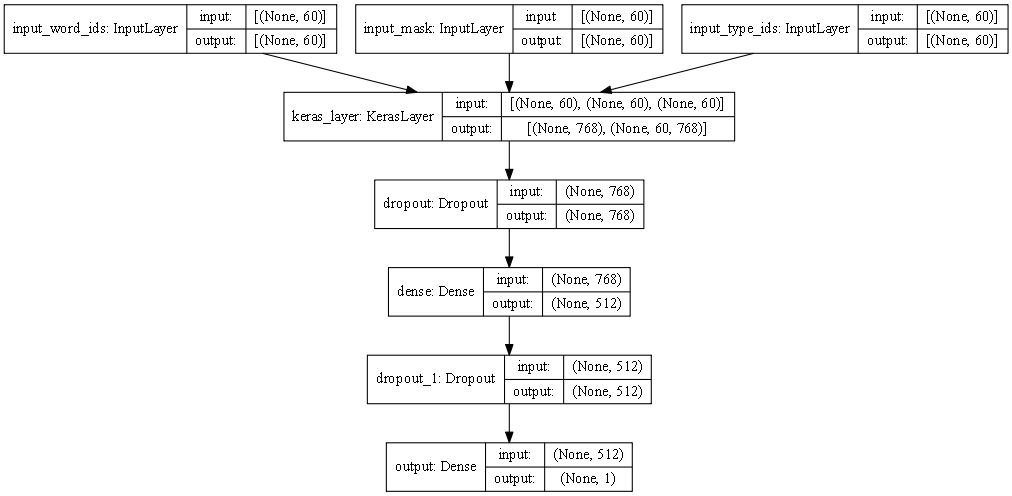

In [23]:
tf.keras.utils.plot_model(model=model_3, show_shapes=True, dpi=76)

In [24]:
# Train model
epochs = 4
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    # tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/Colab_Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
history_3 = model_3.fit(train_data_3, validation_data=valid_data_3, epochs=epochs, verbose=1, callbacks=my_callbacks)

Epoch 1/4
378/378 [==============================] - 82s 194ms/step - loss: 0.6027 - binary_accuracy: 0.6748 - val_loss: 0.5125 - val_binary_accuracy: 0.7545
Epoch 2/4
378/378 [==============================] - 73s 193ms/step - loss: 0.4915 - binary_accuracy: 0.7599 - val_loss: 0.4984 - val_binary_accuracy: 0.7555
Epoch 3/4
378/378 [==============================] - 74s 194ms/step - loss: 0.4099 - binary_accuracy: 0.8089 - val_loss: 0.5507 - val_binary_accuracy: 0.7485


In [25]:
# import tensorflow_addons as tfa
model_4 = create_model()

# Train the entire architecture
# for layer in model.layers[:4]: 
#     layer.trainable = False
    
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [26]:
# Train model
epochs = 4
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    # tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/Colab_Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
history_4 = model_4.fit(train_data_4, validation_data=valid_data_4, epochs=epochs, verbose=1, callbacks=my_callbacks)

Epoch 1/4
378/378 [==============================] - 76s 188ms/step - loss: 0.4478 - binary_accuracy: 0.8067 - val_loss: 0.3881 - val_binary_accuracy: 0.8284
Epoch 2/4
378/378 [==============================] - 74s 195ms/step - loss: 0.3465 - binary_accuracy: 0.8611 - val_loss: 0.3953 - val_binary_accuracy: 0.8338


In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

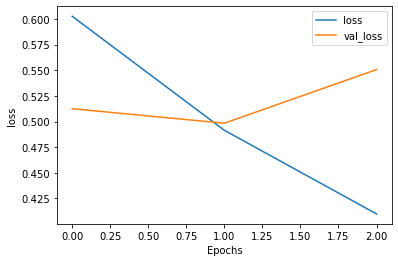

In [28]:
plot_graphs(history_3, 'loss')

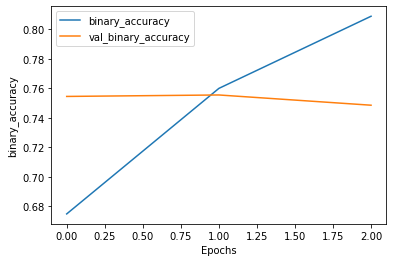

In [29]:
plot_graphs(history_3, 'binary_accuracy')

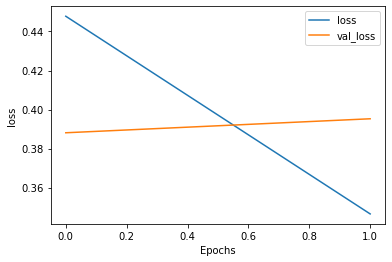

In [30]:
plot_graphs(history_4, 'loss')

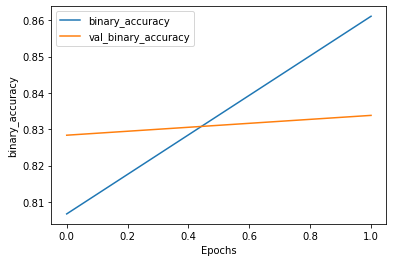

In [31]:
plot_graphs(history_4, 'binary_accuracy')

In [32]:
from sklearn.metrics import classification_report
tt = test_df_3['Original'].tolist()
test_data = tf.data.Dataset.from_tensor_slices((tt, [0]*len(tt)))
test_data = (test_data.map(to_feature_map).batch(1))
preds_probs_3 = model_3.predict(test_data)
preds_3 = (preds_probs_3 > 0.5).astype("int32")
print(classification_report(test_df_3['PrivacyRatio'].tolist(), preds_3))

              precision    recall  f1-score   support

           0       0.68      0.96      0.80       914
           1       0.95      0.63      0.76      1107

    accuracy                           0.78      2021
   macro avg       0.81      0.80      0.78      2021
weighted avg       0.83      0.78      0.78      2021



In [33]:
from sklearn.metrics import classification_report
tt = test_df_4['Original'].tolist()
test_data = tf.data.Dataset.from_tensor_slices((tt, [0]*len(tt)))
test_data = (test_data.map(to_feature_map).batch(1))
preds_probs_4 = model_4.predict(test_data)
preds_4 = (preds_probs_4 > 0.5).astype("int32")
print(classification_report(test_df_4['PrivacyRatio'].tolist(), preds_4))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1282
           1       0.79      0.78      0.78       739

    accuracy                           0.84      2021
   macro avg       0.83      0.83      0.83      2021
weighted avg       0.84      0.84      0.84      2021



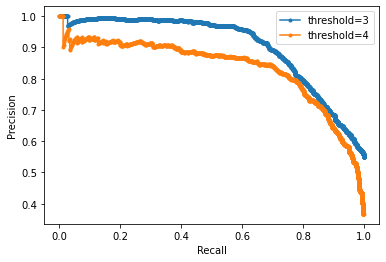

In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_precision_3, lr_recall_3, _ = precision_recall_curve(test_df_3['PrivacyRatio'].tolist(), preds_probs_3)
lr_precision_4, lr_recall_4, _ = precision_recall_curve(test_df_4['PrivacyRatio'].tolist(), preds_probs_4)
pyplot.plot(lr_recall_3, lr_precision_3, marker='.', label='threshold=3')
pyplot.plot(lr_recall_4, lr_precision_4, marker='.', label='threshold=4')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [35]:
lr_f1_3, lr_auc_3 = f1_score(test_df_3['PrivacyRatio'].tolist(), preds_3), auc(lr_recall_3, lr_precision_3)
lr_f1_4, lr_auc_4 = f1_score(test_df_4['PrivacyRatio'].tolist(), preds_4), auc(lr_recall_4, lr_precision_4)
print('Threshold=3: f1=%.3f auc=%.3f' % (lr_f1_3, lr_auc_3))
print('Threshold=4: f1=%.3f auc=%.3f' % (lr_f1_4, lr_auc_4))

Threshold=3: f1=0.759 auc=0.904
Threshold=4: f1=0.785 auc=0.835


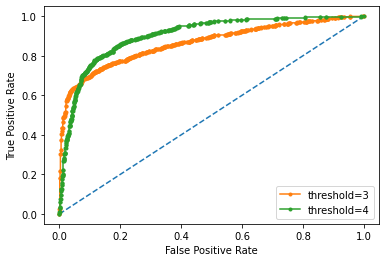

In [36]:
ns_probs = [0 for _ in range(len(test_df_3))]

ns_fpr, ns_tpr, _ = roc_curve(test_df_3['PrivacyRatio'].tolist(), ns_probs)
lr_fpr_3, lr_tpr_3, _ = roc_curve(test_df_3['PrivacyRatio'].tolist(), preds_probs_3)
lr_fpr_4, lr_tpr_4, _ = roc_curve(test_df_4['PrivacyRatio'].tolist(), preds_probs_4)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr_3, lr_tpr_3, marker='.', label='threshold=3')
pyplot.plot(lr_fpr_4, lr_tpr_4, marker='.', label='threshold=4')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [37]:
print('Threshold=3 AUC: %.3f' %(roc_auc_score(test_df_3['PrivacyRatio'].tolist(), preds_probs_3)))
print('Threshold=4 AUC: %.3f' %(roc_auc_score(test_df_4['PrivacyRatio'].tolist(), preds_probs_4)))

Threshold=3 AUC: 0.865
Threshold=4 AUC: 0.904
